In [2]:
# importing libraries 
import pandas as pd 
import numpy as np 
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight







C:\Users\Jack Goodman\AppData\Local\Temp\ipykernel_27404\3228425415.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data = pd.read_csv('E:\COMP2002\insurance_dataset.csv', keep_default_na=False, na_values=['NA', 'na', 'NULL'])

In [4]:
data_encoded = pd.get_dummies(data, columns=['gender', 'smoker', 'region', 'medical_history', 'family_medical_history'], drop_first=True)

for column in data_encoded.columns:
    if data_encoded[column].dtype == 'bool':
        data_encoded[column] = data_encoded[column].astype(int)

In [5]:
print(data_encoded)

        age    bmi  children exercise_frequency    occupation coverage_level  \
0        46  21.45         5              Never   Blue collar        Premium   
1        25  25.38         2       Occasionally  White collar        Premium   
2        38  44.88         2       Occasionally   Blue collar        Premium   
3        25  19.89         0             Rarely  White collar       Standard   
4        49  38.21         3             Rarely  White collar       Standard   
...     ...    ...       ...                ...           ...            ...   
999995   59  46.67         2         Frequently       Student          Basic   
999996   33  36.83         2         Frequently    Unemployed          Basic   
999997   39  39.84         0             Rarely   Blue collar       Standard   
999998   37  45.06         4       Occasionally    Unemployed        Premium   
999999   41  30.02         2       Occasionally   Blue collar       Standard   

             charges  gender_male  smok

In [6]:
# Define the mapping for each column based on the given order.
ordinal_mappings = {
    'exercise_frequency': {'Never': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3},
    'occupation': {'Unemployed': 0, 'Student': 1, 'Blue collar': 2, 'White collar': 3},
    'coverage_level': {'Basic': 0, 'Standard': 1, 'Premium': 2},
    
}



for column, mapping in ordinal_mappings.items():
    data_encoded[column] = data_encoded[column].map(mapping)


In [7]:
print(data_encoded)

        age    bmi  children  exercise_frequency  occupation  coverage_level  \
0        46  21.45         5                   0           2               2   
1        25  25.38         2                   2           3               2   
2        38  44.88         2                   2           2               2   
3        25  19.89         0                   1           3               1   
4        49  38.21         3                   1           3               1   
...     ...    ...       ...                 ...         ...             ...   
999995   59  46.67         2                   3           1               0   
999996   33  36.83         2                   3           0               0   
999997   39  39.84         0                   1           2               1   
999998   37  45.06         4                   2           0               2   
999999   41  30.02         2                   2           2               1   

             charges  gender_male  smok

In [8]:
features = data_encoded.drop(columns=['charges', 'coverage_level'])
coverage_level = data_encoded['coverage_level']
charges = data_encoded['charges']



In [9]:
print(data_encoded.dtypes)

age                                             int64
bmi                                           float64
children                                        int64
exercise_frequency                              int64
occupation                                      int64
coverage_level                                  int64
charges                                       float64
gender_male                                     int32
smoker_yes                                      int32
region_northwest                                int32
region_southeast                                int32
region_southwest                                int32
medical_history_Heart disease                   int32
medical_history_High blood pressure             int32
medical_history_None                            int32
family_medical_history_Heart disease            int32
family_medical_history_High blood pressure      int32
family_medical_history_None                     int32
dtype: object


In [10]:

X_train, X_test, y_coverage_train, y_coverage_test, y_charges_train, y_charges_test = train_test_split(
    features, coverage_level, charges, test_size=0.1, random_state=42)


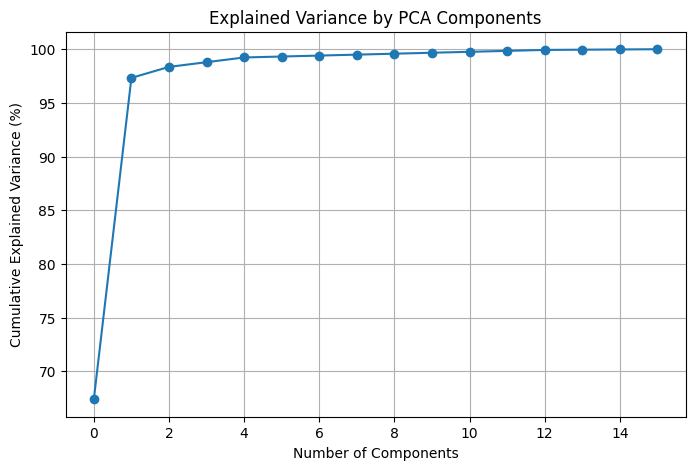

[ 67.40585939  97.33070813  98.35467086  98.79354405  99.23179618
  99.3198854   99.40794739  99.49587273  99.58377761  99.67153477
  99.75918814  99.84676659  99.93419749  99.95617949  99.97810002
 100.        ]


In [11]:
# Assuming 'inputs' is your pre-processed dataset (excluding the target variable)
pca = PCA().fit(features)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_) * 100

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Optionally, print the cumulative explained variance
print(cumulative_explained_variance)

In [12]:
# Initialize the scaler
scaler_X = StandardScaler()
scaler_y_coverage = StandardScaler()
scaler_y_charges = StandardScaler()

# Scale features
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale targets
#y_coverage_train_scaled = scaler_y_coverage.fit_transform(y_coverage_train.values.reshape(-1, 1)).ravel()
#y_coverage_test_scaled = scaler_y_coverage.transform(y_coverage_test.values.reshape(-1, 1)).ravel()
y_charges_train_scaled = scaler_y_charges.fit_transform(y_charges_train.values.reshape(-1, 1)).ravel()
y_charges_test_scaled = scaler_y_charges.transform(y_charges_test.values.reshape(-1, 1)).ravel()

# Initialize PCA
pca = PCA(n_components=8)  # Use the appropriate number of components

# Apply PCA to features
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [13]:
# Define the simple model architecture with L2 regularization
def build_simple_model(input_shape, l2_lambda):
    input_layer = Input(shape=input_shape)
    hidden_layer = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(input_layer)
    charges_output = Dense(1, name='charges_output')(hidden_layer)
    coverage_output = Dense(3, activation='softmax', name='coverage_output')(hidden_layer)
    model = Model(inputs=input_layer, outputs=[charges_output, coverage_output])
    return model



In [14]:
# Define the complex model architecture with L2 regularization
def build_complex_model(input_shape, l2_lambda):
    input_layer = Input(shape=input_shape)
    hidden_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(input_layer)
    hidden_layer = Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(hidden_layer)
    hidden_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(hidden_layer)
    charges_output = Dense(1, name='charges_output')(hidden_layer)
    coverage_output = Dense(3, activation='softmax', name='coverage_output')(hidden_layer)
    model = Model(inputs=input_layer, outputs=[charges_output, coverage_output])
    return model

In [15]:
l2_lambda = 0.01
input_shape = (X_train_pca.shape[1],)

simple_model = build_simple_model(input_shape, l2_lambda)
complex_model = build_complex_model(input_shape, l2_lambda)

# Compile the simple model
simple_model.compile(optimizer='adam',
                     loss={'charges_output': 'mean_squared_error', 'coverage_output': 'sparse_categorical_crossentropy'},
                     metrics={'charges_output': 'mse', 'coverage_output': 'accuracy'})
simple_history = simple_model.fit(
    x=X_train_pca,
    y={'charges_output': y_charges_train, 'coverage_output': y_coverage_train},
    #sample_weight=sample_weight,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)


# Compile the complex model


Epoch 1/100
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 21s 882us/step - charges_output_mse: 224668480.0000 - coverage_output_accuracy: 0.3330 - loss: 224668544.0000 - val_charges_output_mse: 15728992.0000 - val_coverage_output_accuracy: 0.3329 - val_loss: 15729265.0000
Epoch 2/100
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 19s 837us/step - charges_output_mse: 14868998.0000 - coverage_output_accuracy: 0.3340 - loss: 14869250.0000 - val_charges_output_mse: 13197251.0000 - val_coverage_output_accuracy: 0.3333 - val_loss: 13197478.0000
Epoch 3/100
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 20s 870us/step - charges_output_mse: 13104600.0000 - coverage_output_accuracy: 0.3324 - loss: 13104798.0000 - val_charges_output_mse: 12610896.0000 - val_coverage_output_accuracy: 0.3338 - val_loss: 12611056.0000
Epoch 4/100
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 19s 844us/step - charges_output_mse: 12679580.0000 - coverage_output_accuracy: 0.3328 - loss: 12679754.0000 - val_charges_output_mse: 12409112.0000 - val_coverage_output_accuracy:

KeyboardInterrupt: 

In [16]:
complex_model.compile(optimizer='adam',
                      loss={'charges_output': 'mean_squared_error', 'coverage_output': 'sparse_categorical_crossentropy'},
                      metrics={'charges_output': 'mse', 'coverage_output': 'accuracy'})
complex_history = complex_model.fit(
    x=X_train_pca,
    y={'charges_output': y_charges_train, 'coverage_output': y_coverage_train},
    #sample_weight=sample_weight,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/100
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 22s 926us/step - charges_output_mse: 25985402.0000 - coverage_output_accuracy: 0.3324 - loss: 25985428.0000 - val_charges_output_mse: 12150152.0000 - val_coverage_output_accuracy: 0.3343 - val_loss: 12150176.0000
Epoch 2/100
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - charges_output_mse: 12151665.0000 - coverage_output_accuracy: 0.3328 - loss: 12151693.0000 - val_charges_output_mse: 12014718.0000 - val_coverage_output_accuracy: 0.3343 - val_loss: 12014739.0000
Epoch 3/100
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - charges_output_mse: 12132460.0000 - coverage_output_accuracy: 0.3326 - loss: 12132481.0000 - val_charges_output_mse: 12017033.0000 - val_coverage_output_accuracy: 0.3333 - val_loss: 12017059.0000
Epoch 4/100
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - charges_output_mse: 12185760.0000 - coverage_output_accuracy: 0.3334 - loss: 12185788.0000 - val_charges_output_mse: 12045376.0000 - val_coverage_output_accuracy: 0.3336 

In [ ]:
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_pca)
mse = mean_squared_error(y_charges_test, y_pred)
print(f"Mean Squared Error: {mse}")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
# Convert the negative MSE scores to positive
positive_MLP_cv_scores = -MLP_cv_scores

# Plotting the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(positive_MLP_cv_scores)
plt.title("Boxplot of Cross-Validation MSE Scores")
plt.ylabel("Mean Squared Error (MSE)")
plt.xticks([1], ['MLP Regressor'])
plt.grid(True)

# Display the plot
plt.show()

NameError: name 'MLP_cv_scores' is not defined